# Graph visualization using igraph

This notebook demonstrates the use of the TrustGraph triple store API to fetch information from the knowledge graph. This information is then visualized using the igraph visualisation library.  This notebook was executed against a running TrustGraph loaded with the space shuttle challenger report from NASA located here:

https://ntrs.nasa.gov/citations/19860015255

In [1]:
!pip install python-igraph
!pip install cairocffi
!pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import cairocffi as cairo
print("Cairo version:", cairo.version)

Cairo version: 1.17.2


In [3]:
import requests
import json
import igraph as ig

In [4]:
# ID of flow
flow = "default"
base_url = "http://localhost:8088"

In [5]:
# URL of the TrustGraph triples-query API
url = f"{base_url}/api/v1/flow/{flow}/service/triples"

In [6]:
# Utility function, given a label works backward to find the URI of the graph node associated with that label
def get_entity(label):
    
    input = {
        "p": {
            "v": "http://www.w3.org/2000/01/rdf-schema#label",
            "e": True,
        },
        "o": {
            "v": label,
            "e": False,
        },
        "limit": 1,
    }

    # Invoke the API, input is passed as JSON
    resp = requests.post(url, json=input)
    if resp.status_code != 200:
        raise RuntimeError(f"Got status code {resp.status_code}")
    try:
        resp = resp.json()
    except:
        raise RuntimeError("JSON decode failed")

    #print(resp)
    for row in resp["response"]:
        return row["s"]["v"]

    raise RuntimeError("Couldn't resolve entity")


In [7]:
# Given an entity URI, find the label
def get_label(ent):

    if ent == "http://www.w3.org/2000/01/rdf-schema#label": return "label"
    if ent == "https://schema.org/subjectOf": return "subject of"
    if ent.startswith("https://trustgraph.ai/doc/"): return "source document"
    if ent == "http://www.w3.org/2004/02/skos/core#definition": return "definition"
    if ent == "https://schema.org/keywords": return "keyword"
    if ent == "https://schema.org/description": return "keyword"
    if ent == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type": return "type"
    if ent == "https://schema.org/copyrightNotice": return "(c) notice"
    if ent == "https://schema.org/copyrightHolder": return "(c) held"
    if ent == "https://schema.org/copyrightYear": return "(c) year"

    if not ent.startswith("http"): return ent
        
    input = {
        "s": {
            "v": ent,
            "e": True,
        },
        "p": {
            "v": "http://www.w3.org/2000/01/rdf-schema#label",
            "e": True,
        },
        "limit": 1,
    }

    # Invoke the API, input is passed as JSON
    resp = requests.post(url, json=input)
    if resp.status_code != 200:
        raise RuntimeError(f"Got status code {resp.status_code}")
    try:
        resp = resp.json()
    except:
        raise RuntimeError("JSON decode failed")

    for row in resp["response"]:
        label = row["o"]["v"]
        return label
        
    # If no label, just dump the entity
    return ent

In [8]:
# Given a graph node specified by URI, find related edges which start at that node
def get_related_edges(s, limit=20, follows=1):
    
    input = {
        "s": {
            "v": s,
            "e": True,
        },
        "limit": limit, # Limit in number of edges to return
    }

    # Invoke the API, input is passed as JSON
    resp = requests.post(url, json=input)
    if resp.status_code != 200:
        raise RuntimeError(f"Got status code {resp.status_code}")
    try:
        resp = resp.json()
    except:
        raise RuntimeError("JSON decode failed")

    #print(resp)
    res = [
        [s, row["p"]["v"], row["o"]["v"]]
        for row in resp["response"]
    ]

    if follows > 1:
        seeds = [ r[2] for r in res ]
        for se in seeds:
            if se.startswith("http"):
                res.extend(get_related_edges(se, limit, follows - 1))

    return res

In [9]:
# Get some useful starting seeds
shuttle = get_entity("Space Shuttle")
tank = get_entity("fuel tank")
oring = get_entity("O-ring")

In [10]:
# Follow edges start at the seeds above to build a collection of statements
triples = []
triples.extend(get_related_edges(shuttle, 10, 2))
triples.extend(get_related_edges(tank, 10, 1))
triples.extend(get_related_edges(oring, 10, 1))

In [11]:
len(triples)

51

# Visualization

Transfer for graph vis

In [12]:
# Produces a list of entities which are sources and objects.  This list does not contain predicates
ents = list(set([t[0] for t in triples] + [t[2] for t in triples]))
vertex_labels = [ get_label(ent)[:25] for ent in ents]

In [13]:
# URI to ID mapping in both directions
id2uri = { ix: ent for ix, ent in enumerate(ents) }
uri2id = { ent: ix for ix, ent in enumerate(ents) }

# ID to human-readable label for nodes
id2name = { ix: name for ix, name in enumerate(vertex_labels) }

In [14]:
# Edge list, list of (subject, object) pairs
edges = [(uri2id[t[0]], uri2id[t[2]]) for t in triples]

In [15]:
# Mapping from edge to edge label
edge_labels = [ 
    get_label(t[1])[:20] for t in triples
]

In [16]:
g = ig.Graph(n=len(ents), edges=edges, directed=True)
g.vs["label"] = vertex_labels
g.vs["label_size"] = [10] * len(vertex_labels)
g.es["label"] = edge_labels
g.es["label_size"] = [10] * len(edge_labels)

In [17]:
print(g)

IGRAPH D--- 50 51 --
+ attr: label (v), label_size (v), label (e), label_size (e)
+ edges:
25->1 25->43 25->24 25->5 25->39 25->41 25->4 25->28 25->9 25->12 5->36 5->47
39->23 39->7 39->15 39->40 39->32 39->6 39->37 39->14 39->8 39->38 41->2
41->42 41->21 41->29 41->35 41->30 41->13 41->45 41->22 41->18 9->46 9->47
12->3 12->34 12->49 12->47 16->44 16->31 16->47 26->11 26->0 26->19 26->27
26->20 26->17 26->48 26->10 26->33 26->33


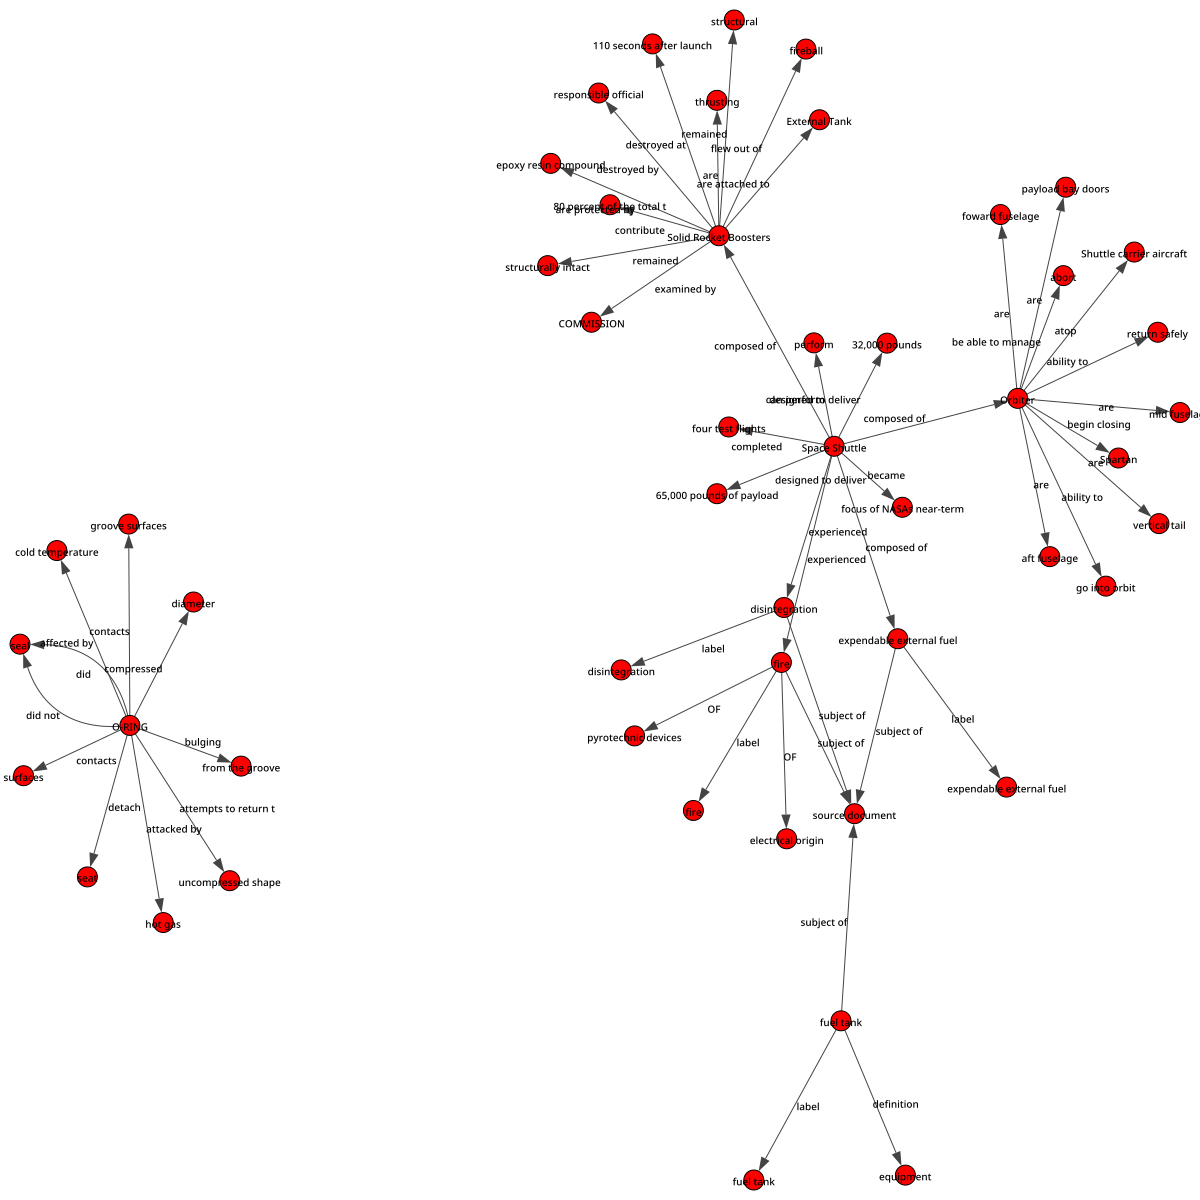

In [18]:
layout = g.layout("kk")
#layout = g.layout("auto")

ig.plot(g, layout=layout, bbox=(0, 0, 1200, 1200))